In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
from t_sne import *
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE as s_TSNE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import scanpy as sc 
import sklearn.metrics as sm
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

import pprint
import copy

## Data preparation

In [4]:
X = pd.read_csv("data/mnist_train.csv")
X_numpy = X.iloc[:6000, 1:].to_numpy().astype('float64')
labels = X.iloc[:6000, 0].values

In [5]:
print(X_numpy[:5])
print(X_numpy.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(6000, 784)


In [6]:
labels

array([5, 0, 4, ..., 8, 6, 9], dtype=int64)

## Evaluation functions

In [114]:
def get_src(data, embedding):
    original_distances = pdist(data, metric='euclidean')
    embedded_distances = pdist(embedding, metric='euclidean')
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    return spearman_corr

def plot_embedding(embedding, labels):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    handles = []
    for i, label in enumerate(np.unique(labels)):
        handle = axs[0].scatter(embedding[labels==label, 0], embedding[labels==label, 1], s=1., label=label)
        handles.append(handle)

    axs[1].legend(handles, np.unique(labels), ncol=2)

    plt.xlabel("EMB1")
    plt.ylabel("EMB2")
    plt.show()

def get_clustering_metrics(embedding, labels, resolution=1):
    anndata = sc.AnnData(embedding)
    sc.pp.neighbors(anndata, use_rep="X")
    sc.tl.leiden(anndata, resolution=resolution)
    cluster_labels = anndata.obs["leiden"].values
    print("Number of Leiden clusters:", np.unique(cluster_labels).shape)
    ari = sm.adjusted_rand_score(labels, cluster_labels)
    ami = sm.adjusted_mutual_info_score(labels, cluster_labels)
    homogeneity = sm.homogeneity_score(labels, cluster_labels)
    completeness = sm.completeness_score(labels, cluster_labels)
    print("""
    ARI: {}\n
    AMI: {}\n
    Homogenuity: {}\n
    Completeness: {}\n
    Avarage: {}
    """.format(ari, ami, homogeneity, completeness, (ari+ami+homogeneity+completeness)/4))
    return ari, ami, homogeneity, completeness

## Experiments

### No optimization

In [8]:
tsne1 = TSNE(
    n_components=2,
    num_iters=1000,
    compression_period=0,
    random_walk=False
)

In [9]:
tsne1.get_highdimensional_similarities(X_numpy)

Finding sigmas


100%|██████████| 6000/6000 [00:28<00:00, 213.61it/s]


In [10]:
Y1 = tsne1.fit()

Running gradient descent...


100%|██████████| 1000/1000 [46:57<00:00,  2.82s/it]


c:\Users\angelo\Documents\studia\22-23\mmml\MMML_project\t_sne.py:467: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


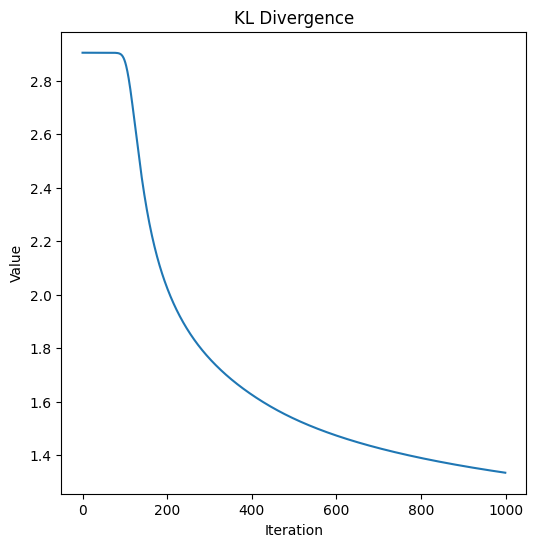

In [11]:
tsne1.plot_metrics()

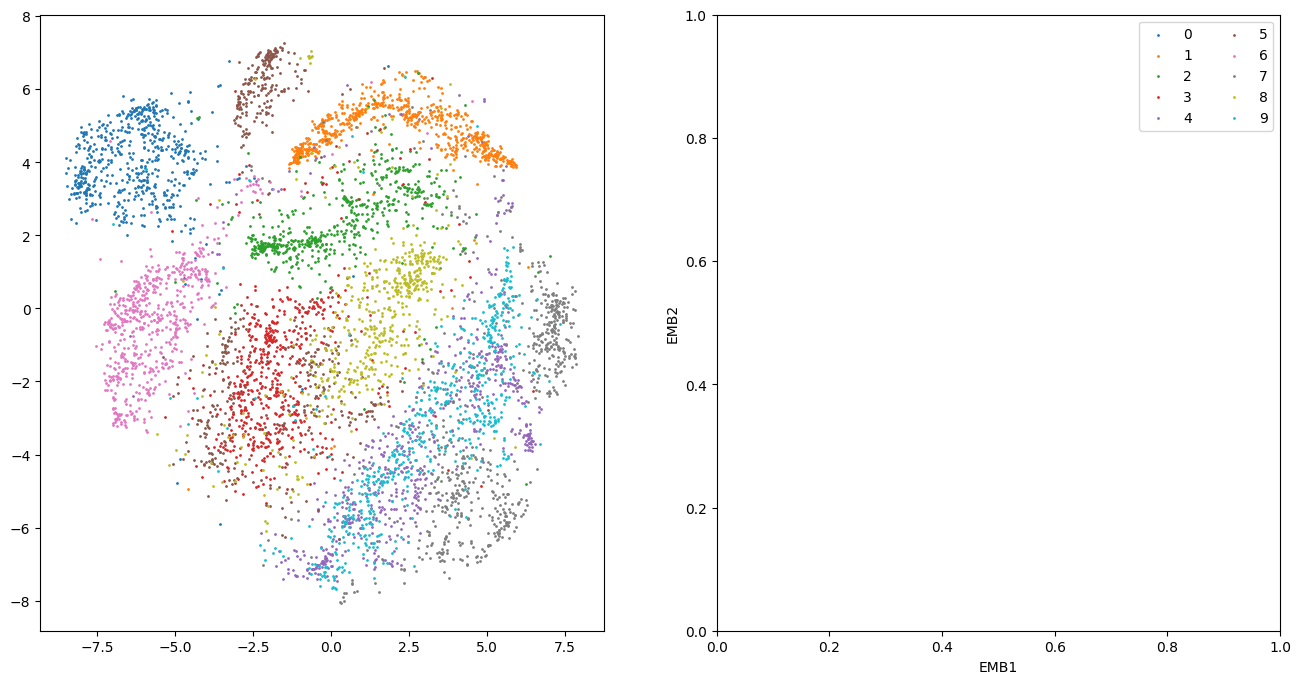

In [12]:
plot_embedding(Y1, labels)

In [13]:
src = get_src(X_numpy, Y1)
kld = tsne1.metrics["kl_divergence"][-1]

print("KLD", kld)
print("SRC", src)

KLD 1.3347786062358713
SRC 0.36544302339962514


In [16]:
get_clustering_metrics(Y1, labels)

Number of Leiden clusters: (6000,)

    ARI: 0.2490067985154305

    AMI: 0.5527900448990136

    Homogenuity: 0.7259387912008367

    Completeness: 0.45244865467813933

    Avarage: 0.49504607232335507
    


(0.2490067985154305,
 0.5527900448990136,
 0.7259387912008367,
 0.45244865467813933)

### Early exaggeration

In [45]:
tsne2 = TSNE(
    n_components=2,
    num_iters=1000,
    compression_period=0,
    ee=True,
    ee_iterations=180,
    random_walk=False
)

In [46]:
tsne2.get_highdimensional_similarities(X_numpy)

Finding sigmas


100%|██████████| 6000/6000 [00:30<00:00, 199.21it/s]


In [47]:
Y2 = tsne2.fit()

Running gradient descent...


100%|██████████| 1000/1000 [46:53<00:00,  2.81s/it]


c:\Users\angelo\Documents\studia\22-23\mmml\MMML_project\t_sne.py:467: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


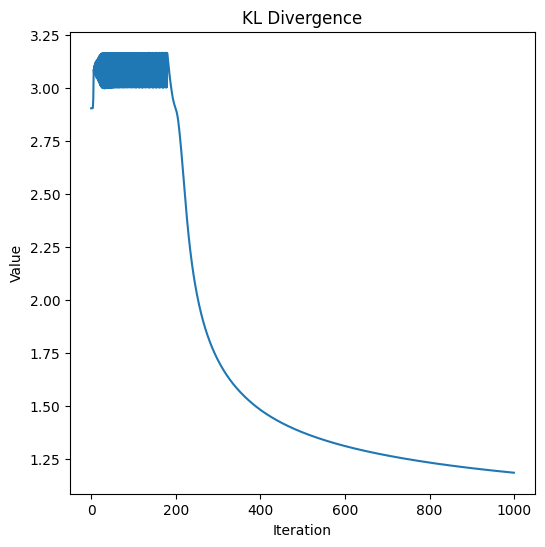

In [49]:
tsne2.plot_metrics()

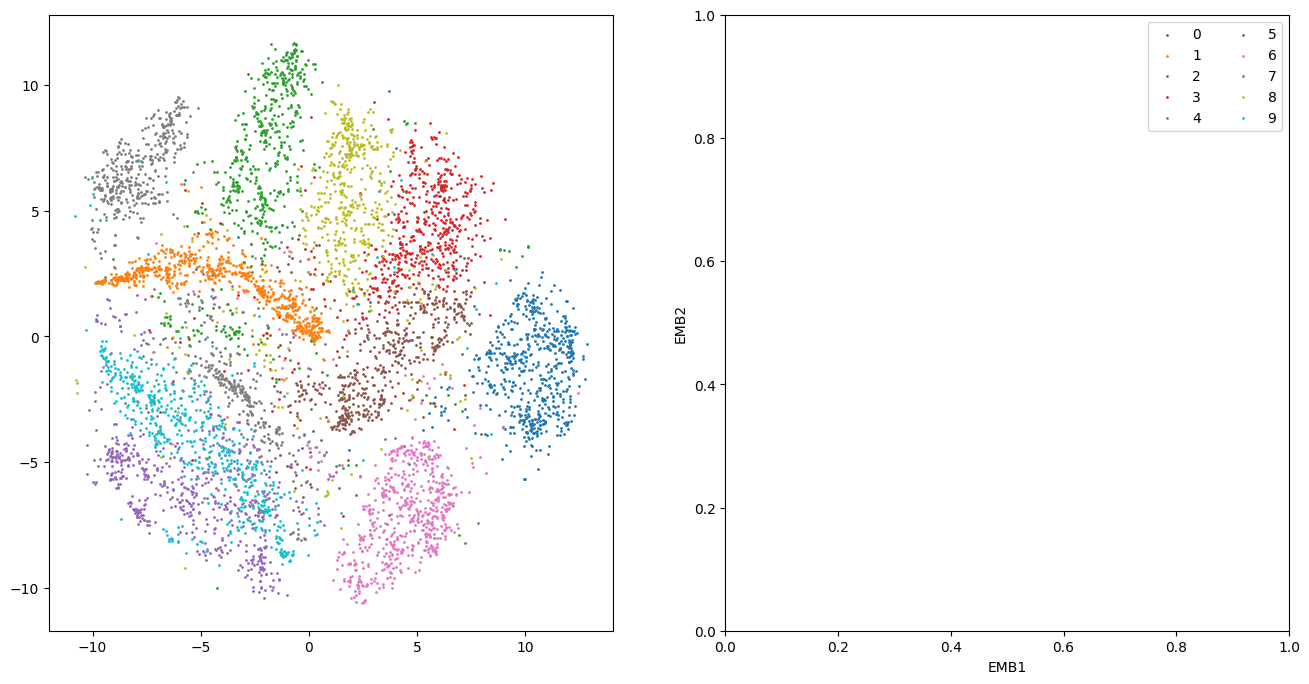

In [50]:
plot_embedding(Y2, labels)

In [51]:
src = get_src(X_numpy, Y2)
kld = tsne2.metrics["kl_divergence"][-1]

print("KLD", kld)
print("SRC", src)

KLD 1.1852943547392953
SRC 0.446960975274996


In [53]:
get_clustering_metrics(Y2, labels)

Number of Leiden clusters: (6000,)

    ARI: 0.26805397455546925

    AMI: 0.5749720924382792

    Homogenuity: 0.7561439433151084

    Completeness: 0.46977313473318505

    Avarage: 0.5172357862605105
    


(0.26805397455546925,
 0.5749720924382792,
 0.7561439433151084,
 0.46977313473318505)

Different number of iterations

In [75]:
tsne21 = TSNE(
    n_components=2,
    num_iters=1000,
    compression_period=0,
    ee=True,
    ee_iterations=600,
    random_walk=False
)

In [76]:
tsne21.get_highdimensional_similarities(X_numpy)

Finding sigmas


100%|██████████| 6000/6000 [00:30<00:00, 197.77it/s]


In [77]:
Y21 = tsne21.fit()

Running gradient descent...


100%|██████████| 1000/1000 [47:12<00:00,  2.83s/it]


c:\Users\angelo\Documents\studia\22-23\mmml\MMML_project\t_sne.py:467: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


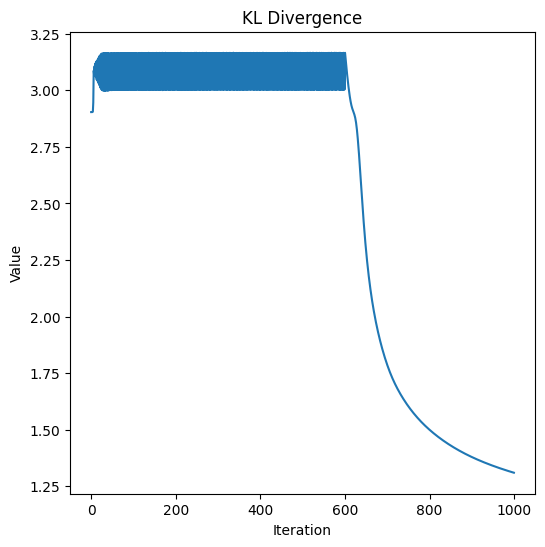

In [78]:
tsne21.plot_metrics()

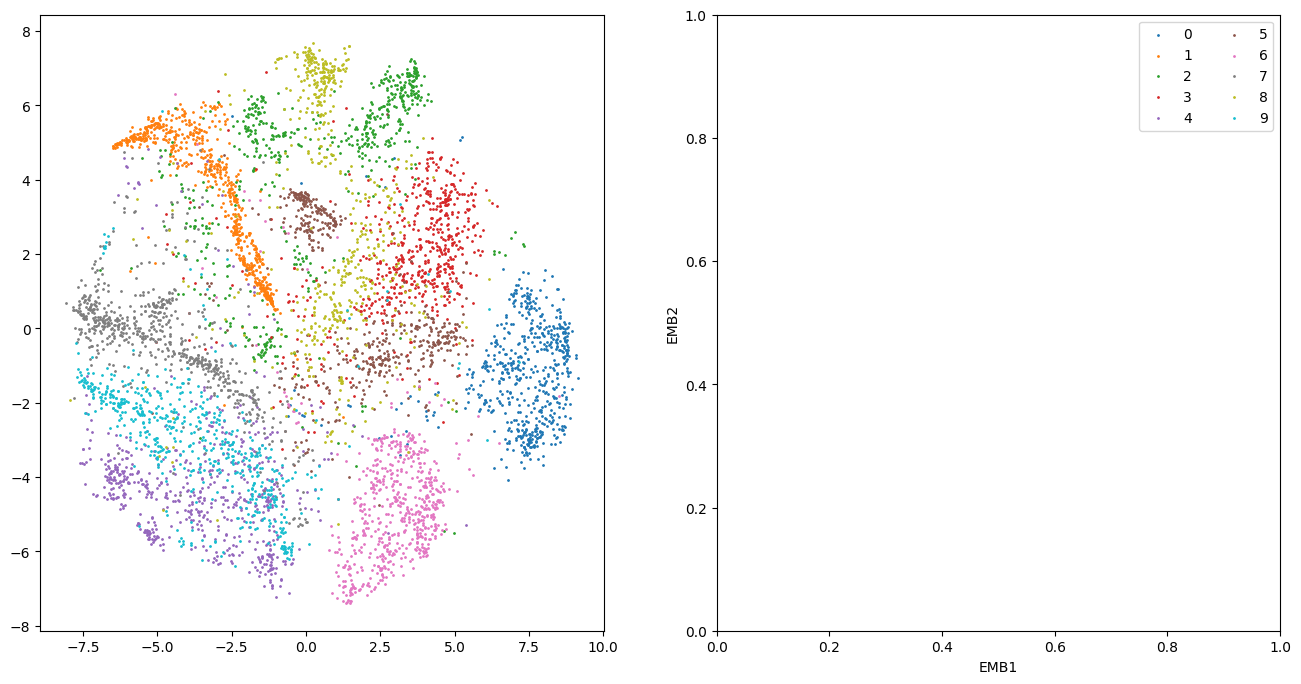

In [79]:
plot_embedding(Y21, labels)

In [80]:
src = get_src(X_numpy, Y21)
kld = tsne21.metrics["kl_divergence"][-1]

print("KLD", kld)
print("SRC", src)

KLD 1.309676100506225
SRC 0.43969978559084455


In [81]:
get_clustering_metrics(Y21, labels)

Number of Leiden clusters: (6000,)

    ARI: 0.2605391497192084

    AMI: 0.5628090246944168

    Homogenuity: 0.7344740503452548

    Completeness: 0.46210733153826317

    Avarage: 0.5049823890742858
    


(0.2605391497192084,
 0.5628090246944168,
 0.7344740503452548,
 0.46210733153826317)

#### Meaningful initialization

In [119]:
tsne3 = TSNE(
    n_components=2,
    num_iters=1000,
    compression_period=0,
    ee=True,
    ee_iterations=200,
    initialization="pca",
    random_walk=False
)

In [120]:
tsne3.get_highdimensional_similarities(X_numpy)

Finding sigmas


100%|██████████| 6000/6000 [00:27<00:00, 216.45it/s]


In [121]:
Y3 = tsne3.fit()

Running gradient descent...


100%|██████████| 1000/1000 [46:46<00:00,  2.81s/it]


c:\Users\angelo\Documents\studia\22-23\mmml\MMML_project\t_sne.py:473: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


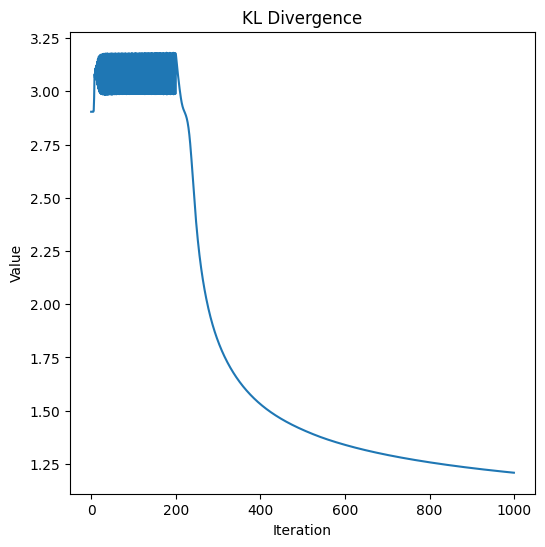

In [122]:
tsne3.plot_metrics()

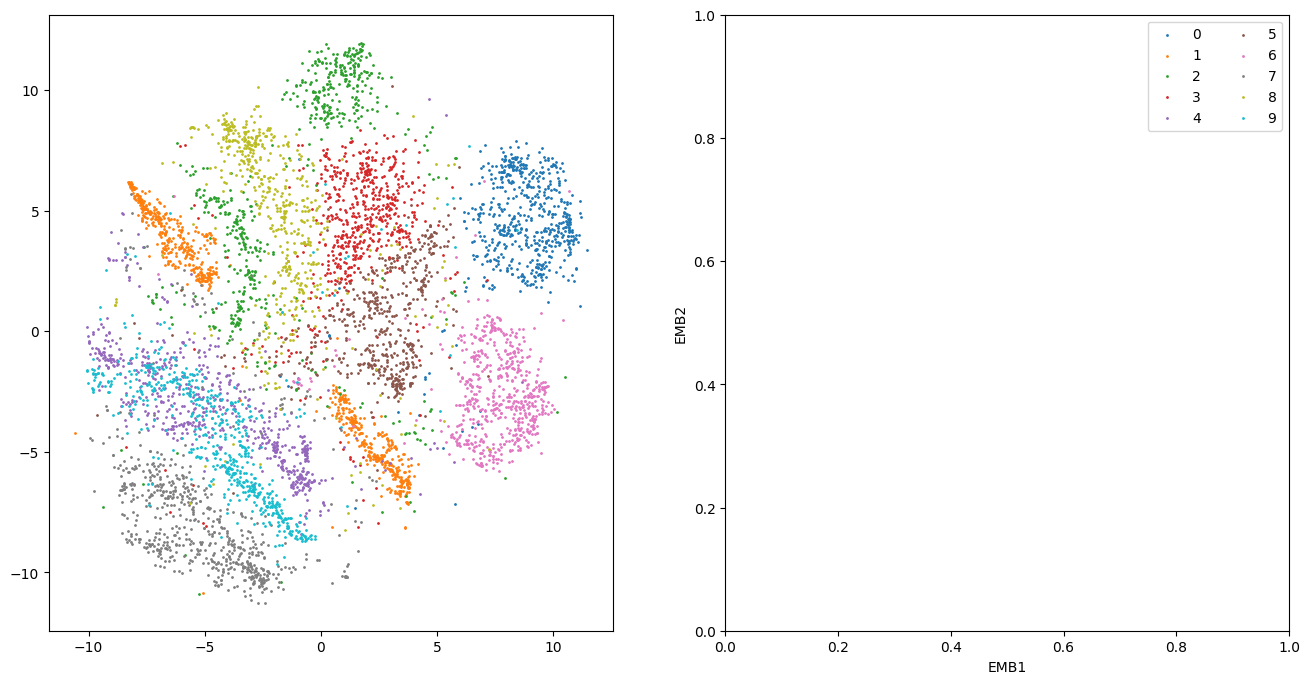

In [123]:
plot_embedding(Y3, labels)

In [124]:
src = get_src(X_numpy, Y3)
kld = tsne21.metrics["kl_divergence"][-1]

print("KLD", kld)
print("SRC", src)

KLD 1.309676100506225
SRC 0.4125768112556237


In [125]:
get_clustering_metrics(Y3, labels)

Number of Leiden clusters: (46,)

    ARI: 0.25568108272671086

    AMI: 0.5735139938458966

    Homogenuity: 0.7610386008930159

    Completeness: 0.4664424506958168

    Avarage: 0.51416903204036
    


(0.25568108272671086,
 0.5735139938458966,
 0.7610386008930159,
 0.4664424506958168)